# L2Circuits, a.k.a. Martini Circuits, and Netmiko

* FEC type 128
* Simplier config than Kompella circuits, but no auto-discovery and potentially more state for the network to maintain
* No ability to advertise a block of labels
* MTU and VLAN advertised in LDP Label Mapping Message

  
## Topology
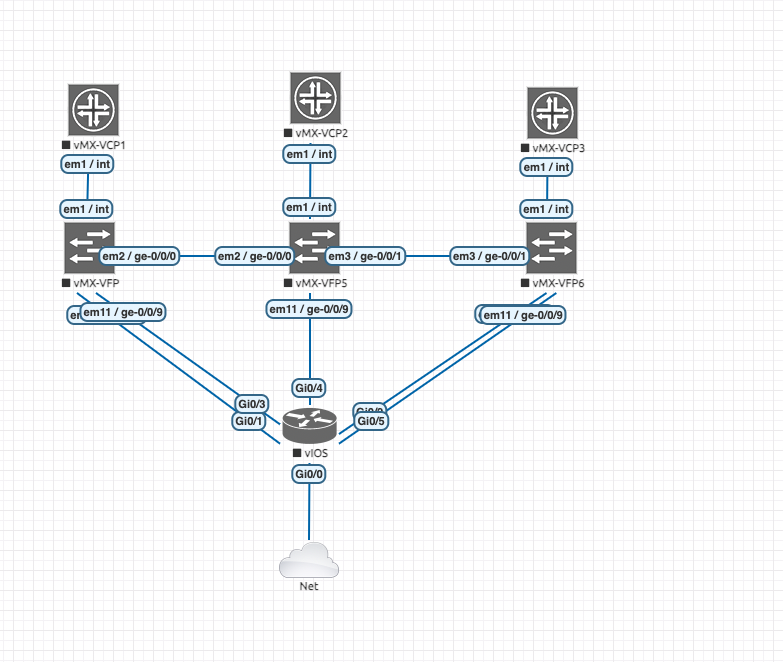

In [1]:
import configparser
from netmiko import ConnectHandler, file_transfer

In [104]:
def backup_to_file(connection, file_name):
    """
    Create backup file locally and on target device.
    """
    backup = connection.send_command("show configuration | display set")
    # TODO: should be able to copy the file from laptop to device rather than saving on device
    # for load_from_backup, but loading file directly from device copy for now
    # TODO: Add confirmation before overwriting file
    connection.send_command("show configuration | save /var/tmp/{file_name}")
    with open(file_name, "w") as file:
        file.write(backup)
    print("Backup saved!")

def load_from_backup(connection, file_name):
    """
    Reload from backup file on target device.
    """
    # TODO: see todo from `backup_to_file` above
    connection.send_config_set([f"load override /var/tmp/{file_name}"])
    print("Loaded file to running config")
    connection.commit(and_quit=True)
    print("Commited")

In [3]:
# Load credentials from .ini file
config = configparser.ConfigParser()
config.read("logins.ini")

devices_login_info = {}
for device in config.sections():
    devices_login_info[device] = {}
    devices_login_info[device]["host"] = config[device]["host"]
    devices_login_info[device]["device_type"] = config[device]["device_type"]
    devices_login_info[device]["username"] = config[device]["username"]
    devices_login_info[device]["password"] = config[device]["password"]

for device, login_info in devices_login_info.items():
    try:
        globals()[device] = ConnectHandler(**login_info)  # Assign key as variable name
        print(f"Creating Netmiko ConnectHandler for {device}")
    except:
        print(f"Error connecting to {device}.")

Creating Netmiko ConnectHandler for PE1
Creating Netmiko ConnectHandler for P
Creating Netmiko ConnectHandler for PE2


In [4]:
print(PE1.send_command("show configuration interfaces | display set"))
print()
print(PE1.send_command("show route table inet.0 protocol isis"))
print()
print(PE1.send_command("show route table inet.3 protocol ldp"))
#backup_to_file(PE1, "PE1_base_config.txt")

set interfaces ge-0/0/0 description TO-P3
set interfaces ge-0/0/0 unit 0 family inet address 10.1.3.1/24
set interfaces ge-0/0/0 unit 0 family iso
set interfaces ge-0/0/0 unit 0 family mpls
set interfaces ge-0/0/1 description TO-CE1
set interfaces ge-0/0/9 description Management
set interfaces ge-0/0/9 unit 0 family inet address 10.142.142.1/30
set interfaces fxp0 unit 0 family inet dhcp vendor-id Juniper-vmx-VM67A0AECE87
set interfaces lo0 unit 0 family inet address 1.1.1.1/32
set interfaces lo0 unit 0 family iso address 49.0001.0001.0001.0001.00



inet.0: 10 destinations, 10 routes (10 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

2.2.2.2/32         *[IS-IS/18] 01:24:19, metric 200
                    > to 10.1.3.3 via ge-0/0/0.0
3.3.3.3/32         *[IS-IS/18] 01:25:49, metric 100
                    > to 10.1.3.3 via ge-0/0/0.0
10.2.3.0/24        *[IS-IS/18] 01:25:49, metric 200
                    > to 10.1.3.3 via ge-0/0/0.0



inet.3: 2 destinations,

In [107]:
print(PE2.send_command("show configuration interfaces | display set"))
print()
print(PE2.send_command("show route table inet.0 protocol isis"))
print()
print(PE2.send_command("show route table inet.3 protocol ldp"))
#backup_to_file(PE2, "PE2_base_config.txt")

set interfaces ge-0/0/1 description TO-P3
set interfaces ge-0/0/1 unit 0 family inet address 10.2.3.2/24
set interfaces ge-0/0/1 unit 0 family iso
set interfaces ge-0/0/1 unit 0 family mpls
set interfaces ge-0/0/2 description TO-CE2
set interfaces ge-0/0/9 description Management
set interfaces ge-0/0/9 unit 0 family inet address 10.142.142.9/30
set interfaces fxp0 unit 0 family inet dhcp vendor-id Juniper-vmx-VM67A0B0354E
set interfaces lo0 unit 0 family inet address 2.2.2.2/32
set interfaces lo0 unit 0 family iso address 49.0001.0002.0002.0002.00



inet.0: 10 destinations, 10 routes (10 active, 0 holddown, 0 hidden)
+ = Active Route, - = Last Active, * = Both

1.1.1.1/32         *[IS-IS/18] 04:10:09, metric 200
                    > to 10.2.3.3 via ge-0/0/1.0
3.3.3.3/32         *[IS-IS/18] 04:10:18, metric 100
                    > to 10.2.3.3 via ge-0/0/1.0
10.1.3.0/24        *[IS-IS/18] 04:10:18, metric 200
                    > to 10.2.3.3 via ge-0/0/1.0



inet.3: 2 destinations,

In [26]:
#load_from_backup(PE2, "PE2_base_config.txt")

Loaded file to running config
Commited


## Create Targeted LDP sessions between PE router loopbacks
* Permit TCP/UDP 646 (or just don't block it)
* Comes up with the L2circuit

In [33]:
targeted_ldp_commands = [
    "set protocols ldp interface lo0.0",
]
PE1.send_config_set(targeted_ldp_commands)
PE1.commit(and_quit=True)
PE2.send_config_set(targeted_ldp_commands)
PE2.commit(and_quit=True);

In [34]:
# Verify LDP is configured on loopbacks
print(PE1.send_command("show configuration protocols ldp"))
print(PE2.send_command("show configuration protocols ldp"))

interface ge-0/0/0.0;
interface lo0.0;

interface ge-0/0/1.0;
interface lo0.0;



## Martini Circuit with Type 4 Ethernet-VLAN Encapsulation

In [44]:
# Create two PWs using Type4 Ethernet-VLAN Encapuslation, one with and one without `pseudowire-status-tlv` for tshoot comparision:
martini_circuit_commands_pe1 = [
    "delete interfaces ge-0/0/1",
    "delete protocols l2circuit neighbor 2.2.2.2",
    "set interfaces ge-0/0/1 flexible-vlan-tagging",
    "set interfaces ge-0/0/1 encapsulation flexible-ethernet-services",
    "set interfaces ge-0/0/1 unit 200 encapsulation vlan-ccc",
    "set interfaces ge-0/0/1 unit 200 vlan-id 200",
    "set interfaces ge-0/0/1 unit 300 encapsulation vlan-ccc",
    "set interfaces ge-0/0/1 unit 300 vlan-id 300",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.200 virtual-circuit-id 200 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.300 virtual-circuit-id 300",
]
PE1.send_config_set(martini_circuit_commands_pe1)
PE1.commit(and_quit=True)

# Mirror config for PE2
martini_circuit_commands_pe2 = [
    "delete interfaces ge-0/0/2",
    "delete protocols l2circuit neighbor 1.1.1.1",
    "set interfaces ge-0/0/2 flexible-vlan-tagging",
    "set interfaces ge-0/0/2 encapsulation flexible-ethernet-services",
    "set interfaces ge-0/0/2 unit 200 encapsulation vlan-ccc",
    "set interfaces ge-0/0/2 unit 200 vlan-id 200",
    "set interfaces ge-0/0/2 unit 300 encapsulation vlan-ccc",
    "set interfaces ge-0/0/2 unit 300 vlan-id 300",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.200 virtual-circuit-id 200 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.300 virtual-circuit-id 300",
]
PE2.send_config_set(martini_circuit_commands_pe2)
PE2.commit(and_quit=True);

In [48]:
# Verifiy the Martini PWs are up and their configs:
print(PE1.send_command("show configuration | display set | match ge-0/0/1"))
print(PE1.send_command("show configuration protocols l2circuit"))
print(PE1.send_command("show l2circuit connections"))

set interfaces ge-0/0/1 flexible-vlan-tagging
set interfaces ge-0/0/1 encapsulation flexible-ethernet-services
set interfaces ge-0/0/1 unit 200 encapsulation vlan-ccc
set interfaces ge-0/0/1 unit 200 vlan-id 200
set interfaces ge-0/0/1 unit 300 encapsulation vlan-ccc
set interfaces ge-0/0/1 unit 300 vlan-id 300
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.200 virtual-circuit-id 200
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.200 pseudowire-status-tlv
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.300 virtual-circuit-id 300

neighbor 2.2.2.2 {
    interface ge-0/0/1.200 {
        virtual-circuit-id 200;
        pseudowire-status-tlv;
    }
    interface ge-0/0/1.300 {
        virtual-circuit-id 300;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NP -- interface h/w not present   
MM -- mtu mismatch               Dn -- down                       
EM -- encapsulation mismatch     VC-D

In [51]:
# Verifiy the Martini PWs are up and their configs:
print(PE2.send_command("show configuration | display set | match ge-0/0/2"))
print(PE2.send_command("show configuration protocols l2circuit"))
print(PE2.send_command("show l2circuit connections"))

set interfaces ge-0/0/2 flexible-vlan-tagging
set interfaces ge-0/0/2 encapsulation flexible-ethernet-services
set interfaces ge-0/0/2 unit 200 encapsulation vlan-ccc
set interfaces ge-0/0/2 unit 200 vlan-id 200
set interfaces ge-0/0/2 unit 300 encapsulation vlan-ccc
set interfaces ge-0/0/2 unit 300 vlan-id 300
set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.200 virtual-circuit-id 200
set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.200 pseudowire-status-tlv
set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.300 virtual-circuit-id 300

neighbor 1.1.1.1 {
    interface ge-0/0/2.200 {
        virtual-circuit-id 200;
        pseudowire-status-tlv;
    }
    interface ge-0/0/2.300 {
        virtual-circuit-id 300;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NP -- interface h/w not present   
MM -- mtu mismatch               Dn -- down                       
EM -- encapsulation mismatch     VC-D

## Martini Circuit with Type 5 Ethernet Encapsulation

In [36]:
# Create one PW using Type5 Ethernet Encapuslation with `pseudowire-status-tlv`
martini_circuit_commands_pe1 = [
    # Remove Type 4 config
    "delete interfaces ge-0/0/1",
    "delete protocols l2circuit neighbor 2.2.2.2",
    # Add Type 5 config 
    "set interfaces ge-0/0/1 encapsulation ethernet-ccc",
    "set interfaces ge-0/0/1 unit 0",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 virtual-circuit-id 4242 pseudowire-status-tlv",
]
PE1.send_config_set(martini_circuit_commands_pe1)
PE1.commit(and_quit=True)

# Mirror config for PE2
martini_circuit_commands_pe2 = [
    # Remove Type 4 config
    "delete interfaces ge-0/0/2",
    "delete protocols l2circuit neighbor 1.1.1.1",
    # Add Type 5 config 
    "set interfaces ge-0/0/2 encapsulation ethernet-ccc",
    "set interfaces ge-0/0/2 unit 0",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 virtual-circuit-id 4242 pseudowire-status-tlv",
]
PE2.send_config_set(martini_circuit_commands_pe2)
PE2.commit(and_quit=True);

In [37]:
# Verifiy the Martini PWs are up and their configs:
print(PE1.send_command("show configuration protocols l2circuit"))
print(PE1.send_command("show l2circuit connections"))

neighbor 2.2.2.2 {
    interface ge-0/0/1.0 {
        virtual-circuit-id 4242;
        pseudowire-status-tlv;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NP -- interface h/w not present   
MM -- mtu mismatch               Dn -- down                       
EM -- encapsulation mismatch     VC-Dn -- Virtual circuit Down    
CM -- control-word mismatch      Up -- operational                
VM -- vlan id mismatch		 CF -- Call admission control failure
OL -- no outgoing label          IB -- TDM incompatible bitrate 
NC -- intf encaps not CCC/TCC    TM -- TDM misconfiguration 
BK -- Backup Connection          ST -- Standby Connection
CB -- rcvd cell-bundle size bad  SP -- Static Pseudowire
LD -- local site signaled down   RS -- remote site standby
RD -- remote site signaled down  HS -- Hot-standby Connection
XX -- unknown

Legend for interface status  
Up -- operational            
Dn -- down                   
Neighbor: 2.2.2.

In [38]:
# Verifiy the Martini PWs are up and their configs:
print(PE2.send_command("show configuration protocols l2circuit"))
print(PE2.send_command("show l2circuit connections"))

neighbor 1.1.1.1 {
    interface ge-0/0/2.0 {
        virtual-circuit-id 4242;
        pseudowire-status-tlv;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NP -- interface h/w not present   
MM -- mtu mismatch               Dn -- down                       
EM -- encapsulation mismatch     VC-Dn -- Virtual circuit Down    
CM -- control-word mismatch      Up -- operational                
VM -- vlan id mismatch		 CF -- Call admission control failure
OL -- no outgoing label          IB -- TDM incompatible bitrate 
NC -- intf encaps not CCC/TCC    TM -- TDM misconfiguration 
BK -- Backup Connection          ST -- Standby Connection
CB -- rcvd cell-bundle size bad  SP -- Static Pseudowire
LD -- local site signaled down   RS -- remote site standby
RD -- remote site signaled down  HS -- Hot-standby Connection
XX -- unknown

Legend for interface status  
Up -- operational            
Dn -- down                   
Neighbor: 1.1.1.

## VLAN Normalization

In [52]:
vlan_normalization_commands_pe1 = [
    "delete interfaces ge-0/0/1",
    "delete protocols l2circuit neighbor 2.2.2.2",
    "set interfaces ge-0/0/1 flexible-vlan-tagging",
    "set interfaces ge-0/0/1 encapsulation flexible-ethernet-services",
    # Swap VLAN 100 to 200 before sending to PE2:
    "set interfaces ge-0/0/1 unit 100 encapsulation vlan-ccc",
    "set interfaces ge-0/0/1 unit 100 vlan-id 100",
    "set interfaces ge-0/0/1 unit 100 input-vlan-map swap",
    "set interfaces ge-0/0/1 unit 100 input-vlan-map vlan-id 200",
    "set interfaces ge-0/0/1 unit 100 output-vlan-map swap",
    # VLAN 300 stays the same
    "set interfaces ge-0/0/1 unit 300 encapsulation vlan-ccc",
    "set interfaces ge-0/0/1 unit 300 vlan-id 300",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.100 virtual-circuit-id 200 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.300 virtual-circuit-id 300",
]
PE1.send_config_set(vlan_normalization_commands_pe1)
PE1.commit(and_quit=True)

# Set PE2 back to Type 4 Ethernet-VLAN encapsulation:
martini_circuit_commands_pe2 = [
    "delete interfaces ge-0/0/2",
    "set interfaces ge-0/0/2 flexible-vlan-tagging",
    "set interfaces ge-0/0/2 encapsulation flexible-ethernet-services",
    "set interfaces ge-0/0/2 unit 200 encapsulation vlan-ccc",
    "set interfaces ge-0/0/2 unit 200 vlan-id 200",
    "set interfaces ge-0/0/2 unit 300 encapsulation vlan-ccc",
    "set interfaces ge-0/0/2 unit 300 vlan-id 300",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.200 virtual-circuit-id 200 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.300 virtual-circuit-id 300",
]
PE2.send_config_set(martini_circuit_commands_pe2)
PE2.commit(and_quit=True);

In [53]:
# Verifiy the Martini PWs are up and their configs:
print(PE1.send_command("show configuration | display set | match ge-0/0/1"))
print(PE1.send_command("show configuration protocols l2circuit"))
print(PE1.send_command("show l2circuit connections"))

set interfaces ge-0/0/1 flexible-vlan-tagging
set interfaces ge-0/0/1 encapsulation flexible-ethernet-services
set interfaces ge-0/0/1 unit 100 encapsulation vlan-ccc
set interfaces ge-0/0/1 unit 100 vlan-id 100
set interfaces ge-0/0/1 unit 100 input-vlan-map swap
set interfaces ge-0/0/1 unit 100 input-vlan-map vlan-id 200
set interfaces ge-0/0/1 unit 100 output-vlan-map swap
set interfaces ge-0/0/1 unit 300 encapsulation vlan-ccc
set interfaces ge-0/0/1 unit 300 vlan-id 300
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.100 virtual-circuit-id 200
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.100 pseudowire-status-tlv
set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.300 virtual-circuit-id 300

neighbor 2.2.2.2 {
    interface ge-0/0/1.100 {
        virtual-circuit-id 200;
        pseudowire-status-tlv;
    }
    interface ge-0/0/1.300 {
        virtual-circuit-id 300;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI --

In [54]:
# Verifiy the Martini PWs are up and their configs:
print(PE2.send_command("show configuration protocols l2circuit"))
print(PE2.send_command("show l2circuit connections"))

neighbor 1.1.1.1 {
    interface ge-0/0/2.200 {
        virtual-circuit-id 200;
        pseudowire-status-tlv;
    }
    interface ge-0/0/2.300 {
        virtual-circuit-id 300;
    }
}

Layer-2 Circuit Connections:

Legend for connection status (St)   
EI -- encapsulation invalid      NP -- interface h/w not present   
MM -- mtu mismatch               Dn -- down                       
EM -- encapsulation mismatch     VC-Dn -- Virtual circuit Down    
CM -- control-word mismatch      Up -- operational                
VM -- vlan id mismatch		 CF -- Call admission control failure
OL -- no outgoing label          IB -- TDM incompatible bitrate 
NC -- intf encaps not CCC/TCC    TM -- TDM misconfiguration 
BK -- Backup Connection          ST -- Standby Connection
CB -- rcvd cell-bundle size bad  SP -- Static Pseudowire
LD -- local site signaled down   RS -- remote site standby
RD -- remote site signaled down  HS -- Hot-standby Connection
XX -- unknown

Legend for interface status  
Up -- op

## Packet Dump

In [91]:
PE1.send_command("clear ldp session 2.2.2.2")
PE2.send_command("clear ldp session 1.1.1.1")
#print(PE1.send_command("show ldp session"))
print(PE1.send_command(
'monitor traffic interface ge-0/0/0 \
matching "port 646 and host 1.1.1.1 and greater 300" \
count 2 \
size 1514 \
no-resolve \
detail',
    read_timeout=30
))
#size 1514 \
#no-resolve \
#layer2-headers \
#detail'
#write-file /var/tmp/ldp_l2.pcap'
print()
print(PE1.send_command("show ldp session"))

Address resolution is OFF.
Listening on ge-0/0/0, capture size 1514 bytes

18:40:58.059559 Out IP (tos 0xc0, ttl  64, id 35395, offset 0, flags [none], proto: TCP (6), length: 282) 1.1.1.1.646 > 2.2.2.2.51069: P 2518532621:2518532851(230) ack 1576598563 win 16352 <nop,nop,timestamp 2160012583 2159883699>: 
	LDP, Label-Space-ID: 1.1.1.1:0, pdu-length: 28
	  Address Message (0x0300), length: 18, Message ID: 0x00000003, Flags: [ignore if unknown]
	    Address List TLV (0x0101), length: 10, Flags: [ignore and don't forward if unknown]
	      Address Family: IPv4, addresses: 1.1.1.1 10.1.3.1
	LDP, Label-Space-ID: 1.1.1.1:0, pdu-length: 194
	  Label Mapping Message (0x0400), length: 28, Message ID: 0x00000004, Flags: [ignore if unknown]
	    FEC TLV (0x0100), length: 8, Flags: [ignore and don't forward if unknown]
	      Prefix FEC (0x02): IPv4 prefix 1.1.1.1/32
	    Generic Label TLV (0x0200), length: 4, Flags: [ignore and don't forward if unknown]
	      Label: 3
	    Unknown TLV (0x0206),

In [79]:
pcap_transfer = file_transfer(PE1, source_file="ldp_l2.pcap", dest_file="my.pcap",
                              direction="get", overwrite_file=True)

## Traceoptions

In [94]:
import time
martini_trace_commands_pe1 = [
    "set protocols l2circuit traceoptions file martini_trace.txt",
    "set protocols l2circuit traceoptions flag connections detail",
    "set protocols l2circuit traceoptions flag fec detail",
]
PE1.send_config_set(martini_trace_commands_pe1)
PE1.commit(and_quit=True)
PE1.send_command("clear ldp session 2.2.2.2")
time.sleep(10)

martini_trace_commands_pe1 = [
    "delete protocols l2circuit traceoptions",
]
PE1.send_config_set(martini_trace_commands_pe1)
PE1.commit(and_quit=True)
print(PE1.send_command("show log martini_trace.txt"))

Feb 6 18:48:42 PE-1 clear-log[8138]: logfile cleared
Feb  6 18:49:12 trace_on: Tracing to "/var/log/martini_trace.txt" started
Feb  6 18:49:12.449928 vc_iflchange  intf ge-0/0/1.100 (index 334) change flags 0x0
Feb  6 18:49:12.449983 adjusted mtu = 1500
Feb  6 18:49:12.450016 [vc_intf_params_change] Intf ge-0/0/1.100: NO Intf Params CHANGE
Feb  6 18:49:12.450049 vc_iflchange  intf ge-0/0/1.300 (index 335) change flags 0x0
Feb  6 18:49:12.450052 adjusted mtu = 1500
Feb  6 18:49:12.450055 [vc_intf_params_change] Intf ge-0/0/1.300: NO Intf Params CHANGE
Feb  6 18:49:12.450972 [vc_ifachange] intf ge-0/0/1.100: new status intf Up (old status intf Up), GF 4
Feb  6 18:49:12.450993 [vc_ifachange] Triggering VC status update timer for intf ge-0/0/1.100
Feb  6 18:49:12.450996        Triggering VC status update timer for intf ge-0/0/1.100
Feb  6 18:49:12.451026 [vc_ifachange] vc (Neighbor : 2.2.2.2, VC-ID : 200), ifl ge-0/0/1.100: status intf Up -> intf Up
Feb  6 18:49:12.451061 [vc_ifachange] in

## L2Circuits / Martini Circuits OAM / VCCV
* VCCV (Virtual Circuit Connectivity Verification)
     * Uses OAM under the l2circuit neighbor interface statement
     * Can use ICMP, LSP ping (UDP 3503), or BFD
     * Sent PER L2CIRCUIT -- Can cause an outage!!!
     * Pick your most important L2Circuits if you do run BFD
     * RFC 5885 and RFC 5085

In [95]:
# Create one PW using Type5 Ethernet Encapuslation with `pseudowire-status-tlv`
martini_circuit_commands_pe1 = [
    # Remove Type 4 config
    "delete interfaces ge-0/0/1",
    "delete protocols l2circuit neighbor 2.2.2.2",
    # Add Type 5 config 
    "set interfaces ge-0/0/1 encapsulation ethernet-ccc",
    "set interfaces ge-0/0/1 unit 0",
    # Set up 
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 virtual-circuit-id 4242 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 oam ping-interval 30", 
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 oam ping-multiplier 3", 
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 oam bfd-liveness-detection minimum-interval 1000", 
    "set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 oam bfd-liveness-detection multiplier 5", 
]
PE1.send_config_set(martini_circuit_commands_pe1)
PE1.commit(and_quit=True)

martini_circuit_commands_pe2= [
    # Remove Type 4 config
    "delete interfaces ge-0/0/2",
    "delete protocols l2circuit neighbor 1.1.1.1",
    # Add Type 5 config 
    "set interfaces ge-0/0/2 encapsulation ethernet-ccc",
    "set interfaces ge-0/0/2 unit 0",
    # Set up 
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 virtual-circuit-id 4242 pseudowire-status-tlv",
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 oam ping-interval 30", 
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 oam ping-multiplier 3", 
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 oam bfd-liveness-detection minimum-interval 1000", 
    "set protocols l2circuit neighbor 1.1.1.1 interface ge-0/0/2.0 oam bfd-liveness-detection multiplier 5", 
]
PE2.send_config_set(martini_circuit_commands_pe2)
PE2.commit(and_quit=True);

In [100]:
print(PE1.send_command("show bfd session"))
print()
print(PE2.send_command("show bfd session extensive"))

                                                  Detect   Transmit
Address                  State     Interface      Time     Interval  Multiplier
127.0.0.1                Up        ge-0/0/0.0     5.000     1.000        5   

1 sessions, 1 clients
Cumulative transmit rate 1.0 pps, cumulative receive rate 1.0 pps


                                                  Detect   Transmit
Address                  State     Interface      Time     Interval  Multiplier
127.0.0.1                Up        ge-0/0/1.0     5.000     1.000        5   
 Client L2CKT-OAM, TX interval 1.000, RX interval 1.000
 Session up time 00:09:25
 Local diagnostic None, remote diagnostic None
 Remote state Up, version 1
 Session type: VCCV BFD
 Min async interval 1.000, min slow interval 1.000
 Adaptive async TX interval 1.000, RX interval 1.000
 Local min TX interval 1.000, minimum RX interval 1.000, multiplier 5
 Remote min TX interval 1.000, min RX interval 1.000, multiplier 5
 Local discriminator 16, remote dis

## L2Circuits / Martini Circuits Multihoming
* `set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 backup-neighbor 4.4.4.4`
* `set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 revert-time 30`


## L2Circuits / Martini Circuits Local Switching
* L2circuit with both client endpoints on same PE router 
* `set protocols l2circuit neighbor 2.2.2.2 interface ge-0/0/1.0 end-interface ge-0/0/2.0` 


## Reload the base config onto the lab routers

In [101]:
load_from_backup(PE1, "PE1_base_config.txt")
load_from_backup(PE2, "PE2_base_config.txt")

Loaded file to running config
Commited
Loaded file to running config
Commited


In [106]:
# Quick sanity check lab is back to base config
print(PE1.send_command('show configuration | display set | match "ge-0/0/1|l2circuit"'))
print(PE2.send_command('show configuration | display set | match "ge-0/0/2|l2circuit"'))

set interfaces ge-0/0/1 description TO-CE1

set interfaces ge-0/0/2 description TO-CE2

